# Sensitivity Analysis on Continuous Features

For this first attempt of sensitivity analysis, I want to understand which continuous features have the most impact on predicting the target outputs, when using two different Machine Learning Techniques: **Random Forest Regressor** and **Sequential Neural Network**. Both techniques are well-suited for capturing complex, non-linear relationships in the data.

### Approach 1 - RandomForestRegressor

In this first approach, I will train a [RandomForestRegressor](https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.RandomForestRegressor.html) for each output, using only the continuous features. The process will be the following:

1. I will train a RandomForest for each of the target outputs.
2. I will extract the [feature importance](https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_) for each model, and rank them.
3. I will show the [Partial Dependence Plot](https://christophm.github.io/interpretable-ml-book/pdp.html) on each of the inputs.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import partial_dependence
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [2]:
df = pd.read_csv('./data/working_df.csv').dropna()  # Replace with your actual file path

# Define inputs and outputs
input_features = ['fdfm', 'lfm', 'wind_speed', 'dash_length', 
                  'gap_length', 'blackline_width', 'spacing_distance', 
                  'igniter_velocity', 'ignition_time']
output_features = ['surface_consumed', 'midstory_consumed', 'canopy_consumed']

models = {}
feature_importances = {}

for output in output_features:
    X_train, X_test, y_train, y_test = train_test_split(df[input_features], df[output], test_size=0.2)
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    models[output] = model

    # Get feature importances and rank them
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': input_features, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    feature_importances[output] = feature_importance_df

    # Display the feature ranking
    print(f"Feature ranking for {output}:")
    print(feature_importance_df)
    print("\n")

Feature ranking for surface_consumed:
            Feature  Importance
8     ignition_time    0.397797
0              fdfm    0.351473
7  igniter_velocity    0.092974
2        wind_speed    0.075126
1               lfm    0.025048
5   blackline_width    0.018863
6  spacing_distance    0.015891
4        gap_length    0.011849
3       dash_length    0.010980


Feature ranking for midstory_consumed:
            Feature  Importance
8     ignition_time    0.346829
0              fdfm    0.155790
7  igniter_velocity    0.153613
1               lfm    0.148756
6  spacing_distance    0.080852
2        wind_speed    0.067837
5   blackline_width    0.028568
4        gap_length    0.012765
3       dash_length    0.004990


Feature ranking for canopy_consumed:
            Feature  Importance
8     ignition_time    0.330748
1               lfm    0.184054
2        wind_speed    0.125127
6  spacing_distance    0.111218
0              fdfm    0.089114
5   blackline_width    0.059493
4        gap_lengt

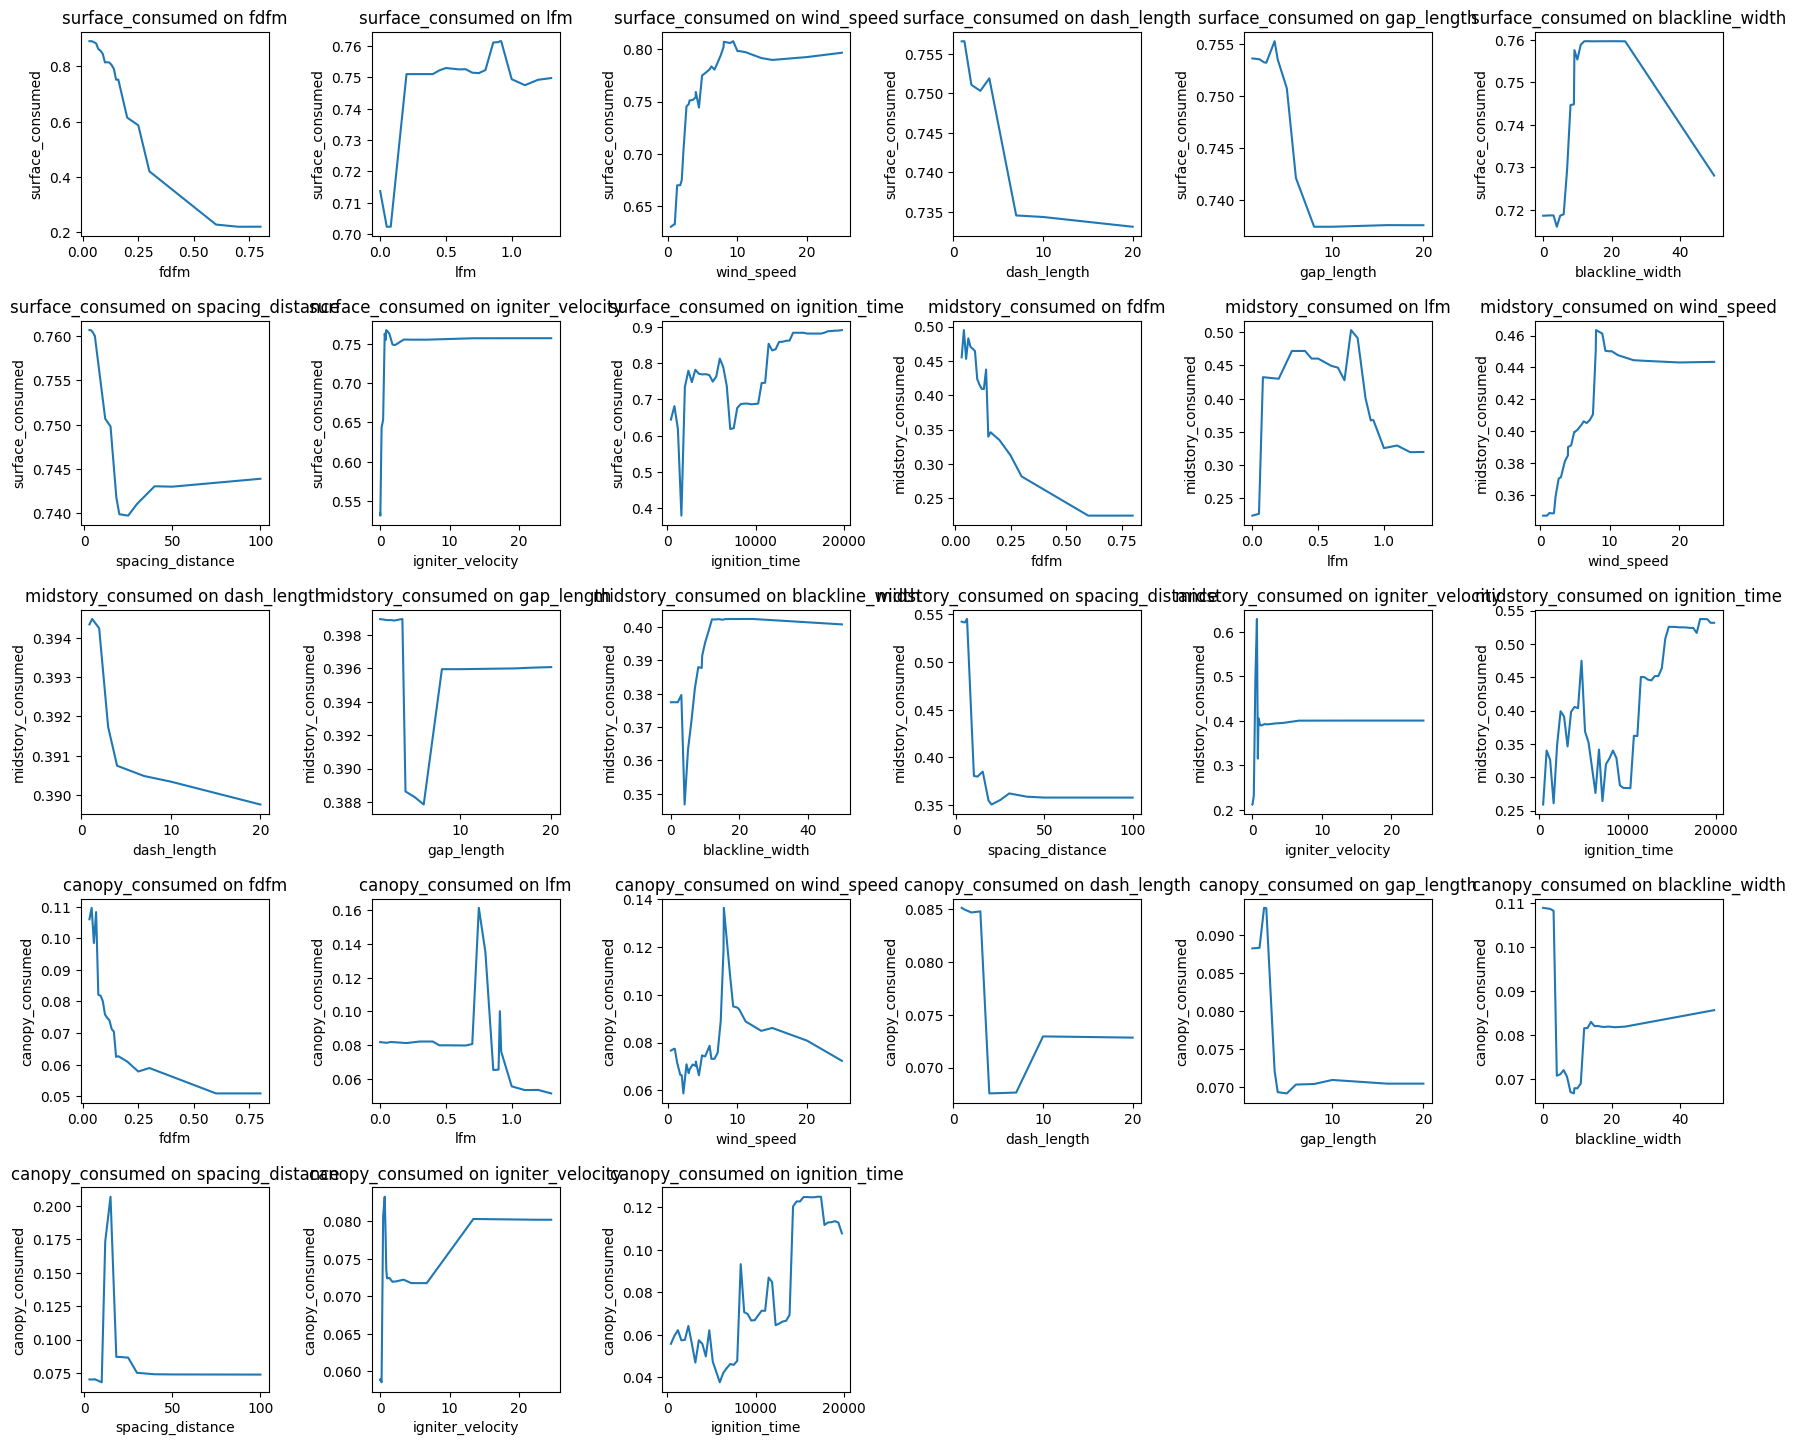

In [3]:
# Set up the grid for partial dependence plots
fig, axes = plt.subplots(5, 6, figsize=(18, 15))  # 5x6 grid, adjust figsize if needed
fig.tight_layout(pad=4.0)  # Adjust padding between plots

# Sensitivity analysis using partial dependence plots
sensitivity_results = {}
plot_index = 0

for output in output_features:
    model = models[output]
    sensitivity_results[output] = {}
    for i, feature in enumerate(input_features):
        # Compute partial dependence for the feature
        pdp_results = partial_dependence(model, X_train, features=[i], grid_resolution=50)
        
        # Extract partial dependence and grid values
        pdp = pdp_results['average'][0]  # First (and only) row of results
        axis_values = pdp_results['grid_values'][0]  # Grid values for the feature
        sensitivity_results[output][feature] = pdp  # Store PDP results
        
        # Determine row and column position in the grid
        row, col = divmod(plot_index, 6)
        
        # Plotting partial dependence in the grid
        ax = axes[row, col]
        ax.plot(axis_values, pdp)
        ax.set_title(f'{output} on {feature}')
        ax.set_xlabel(feature)
        ax.set_ylabel(output)
        
        plot_index += 1

# Hide any empty subplots
for i in range(plot_index, 5*6):
    fig.delaxes(axes.flatten()[i])

plt.show()

These are the first results of our analysis. As we see, the `ignition_time` is the most important feature in all 3 models (which makes sense). It catches my attention the behaviour of `wind_speed`. It would seem that after reaching certain velocity, the marginal effect of the wind speed is lower. It might be worth at some point to segmentate the analysis to only use `wind_speed` at certain levels.

### Approach 2: Sequential Neural Network.

In this second approach, I'm using a fully connected sequential neural network, passing the 9 inputs to predict the 3 outputs simoultaneously (as 3 outputs are using the same inputs). The process is the following:

1. The inputs are scaled to ensure consistent magnitudes, which improves the neural network’s learning proces
2. The model is a fully connected neural network with two hidden layers, each containing 64 neurons and using the [ReLU activation function](https://builtin.com/machine-learning/relu-activation-function). We use the [Adam optimizer](https://www.geeksforgeeks.org/adam-optimizer/) to update the weights. 
3. After training the model, I will perform a [permutation-based sensitivity analysis](https://scikit-learn.org/1.5/modules/permutation_importance.html). In this process, each input feature is shuffled one at a time while the others are held constant. A higher absolute change in the model’s error after shuffling a feature indicates that the outputs are more sensitive to that feature, meaning it has a significant impact on the model’s predictions.4. I will estimate Shapley values and visualize them.
4. Additionally, I will calculate [Shapley (SHAP) values](https://shap.readthedocs.io/en/latest/) to further assess feature importance and visualize the results. SHAP values provide insights into the contribution of each feature to each individual prediction, offering a detailed view of feature importance across different samples.


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Prepare the data
X = df[input_features]
y = df[output_features]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(len(output_features))  # One output node for each output feature
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2)


C:\Users\pramonettivega\AppData\Local\anaconda3\envs\sensitivity-analysis\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1293 - val_loss: 0.0331
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0341 - val_loss: 0.0265
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0278 - val_loss: 0.0241
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0246 - val_loss: 0.0220
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0213 - val_loss: 0.0204
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0205 - val_loss: 0.0197
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0189 - val_loss: 0.0186
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0185 - val_loss: 0.0189
Epoch 9/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0177 - val_loss: 0.0178
Epoch 10/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0172 - val_loss: 0.0171
Epoch 11/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0154 - val_loss: 0.0176
Epoch 12/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0

In [5]:
import numpy as np
from sklearn.metrics import mean_squared_error

def permutation_importance(model, X, y, metric=mean_squared_error):
    base_score = metric(y, model.predict(X))
    feature_importance = []
    for i in range(X.shape[1]):
        X_permuted = X.copy()
        np.random.shuffle(X_permuted[:, i])
        permuted_score = metric(y, model.predict(X_permuted))
        importance = base_score - permuted_score
        feature_importance.append(importance)
    return feature_importance

# Calculate permutation importance
X_test_scaled_np = np.array(X_test_scaled)
importances = permutation_importance(model, X_test_scaled_np, y_test)

# Rank features by importance
feature_importance = dict(zip(input_features, importances))
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1])
print("Feature Importances (Permutation-based):")
for feature, importance in sorted_importance:
    print(f"{feature}: {importance}")


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Feature Importances (Permutation-based):
fdfm: -0.0378283352241708
ignition_time: -0.03692988122792723
igniter_velocity: -0.022564085712510607
lfm: -0.02152363166727005
dash_length: -0.016735494196113428
spacing_distance: -0.012456273462392656
gap_length: -0.012145564487077935
blackline_width: -0.009849607075187308
wind_speed: -0.007477840963504418


In [6]:
import shap

# Initialize the SHAP explainer with a sample of the training data for KernelExplainer
explainer = shap.KernelExplainer(model.predict, X_test_scaled_np[:100])

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_scaled_np, nsamples=100)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  0%|          | 0/823 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
313/313 ━━━━━━

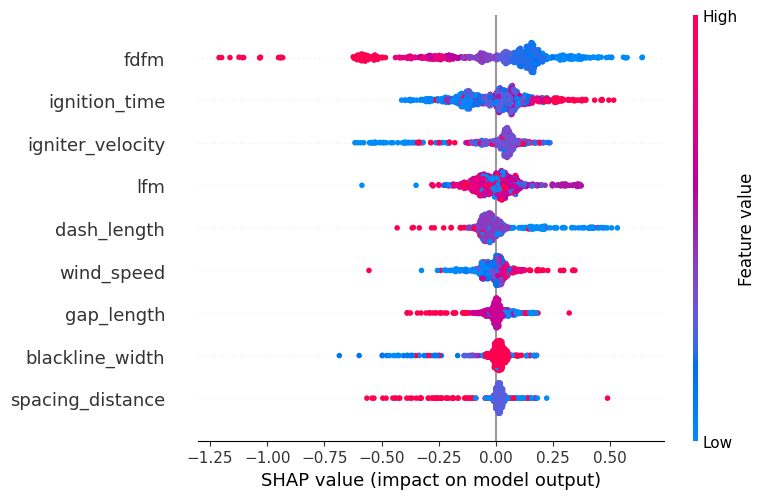

In [7]:
# Summary plot for SHAP values
shap_values_sum = [np.sum(s, axis=1) for s in shap_values]  # Sum along the output axis
shap_values_combined = np.array(shap_values_sum)

# Plot the combined SHAP values
shap.summary_plot(shap_values_combined, X_test_scaled_np, feature_names=input_features)

We can identify consistency between both evaluation methods for the sequential neural network. Both the permutation based analysis and the SHAP values show the same rank of importance among features.

### Next Steps

- Discrete Features - Based Analysis
- Discuss with team different approaches and corrections to current analysis.